## Uncovering Momentum, Section 4

# Explaining the Momentum Effect

This notebook presents the results of the new Section 4 'Explaining the Momentum Effect' for the next version of the [Uncovering Momentum](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3502301) working paper. Section 4 suggests to reconsider the results of [Bandarchuk and Hilscher (2013)](https://academic.oup.com/rof/article-abstract/17/2/809/1596247) regarding the irrelevance between characteristics and momentum profits and redefines extreme past returns as not the source, but mechanism for selecting a porfolio of stocks  with effective combination of fundamental and technical characteristics. For justifying this statement, the section examines within the momentum winners deciles the probability distribution of fundamental characteristics from the [Fama-French model (2015)](https://www.sciencedirect.com/science/article/abs/pii/S0304405X14002323) and a technical characteristic (realized volatility). The results suggest to narrow the scope of analysis to the realized volatility and book-to-market quartiles. **Subsequently, extending the intertemporal analysis to these bivariate quartiles transparently explains momentum decile effect as the sampling of high volatility growth stocks.**

The notebook is structured as follows:
    
<ol>
    <li><a href="#section_1">Connecting Pipeline Engine with Data Bundles</a></li>
    <li><a href="#section_2">Building and Running Pipeline</a></li>
    <li><a href="#section_3">Post-Processing Pipeline Data</a></li>
    <li><a href="#section_4">Screening Features within Top Momentum Decile</a></li>
    <li><a href="#section_5">Delving into Dynamics of Bivariate RV and BP Quartiles</a></li>
    <li><a href="#section_6">Rolling the Intertemporal Analysis Approach</a></li>
</ol>

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
pal = sns.color_palette('hls')

import warnings
warnings.filterwarnings('ignore')

<a id="section_1"></a>
## 1. Connecting Pipeline Engine with Data Bundles

The momentum factors and associated stock characteristics are computed on the pipeline engine of the [Zipline](https://github.com/quantopian/zipline)-based 
research platform. Therefore, as the first step of the application, the engine needs to be connected with 
historical data. 

The Zipline data layer is organized as a collection of named data bundles associated with 
different data sets. The [fsharadar](https://flounderteam.github.io/fsharadar/) extension implements two bundles produced from [Sharadar Equity Prices (SEP)](https://www.quandl.com/databases/SEP/data) 
and [Daily Metrics of Core US Fundamental Data](https://www.quandl.com/databases/SF1/data). According to Zipline, each bundle can be independently accessed 
from the BundleData instance that is retuned by the *load()* method provided by the corresponding submodule, sep 
or daily, respectively. Subsequently, the BundleData instances are used for initializing Pipeline Loaders.

In [2]:
from fsharadar import sep
from fsharadar import daily

sep_bundle_data = sep.load()
daily_bundle_data = daily.load()

sep_pipe_loader = sep.PipelineLoader(sep_bundle_data)
daily_pipe_loader = daily.PipelineLoader(daily_bundle_data)

The Zipline current version provides SimplePipelineEngine that computes each task independently. 
The configuration of this engine requires the definition of *get_loader* function and *asset_finder*. 
The *get_loader* function servers as a dispatcher that returns the appropriate Pipeline Loader 
for retrieving raw data of selected characteristic.

In [3]:
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.data import USEquityPricing

def get_pipe_loader(column):
    if column in USEquityPricing.columns:
        return sep_pipe_loader
    if column in daily.Fundamentals.columns:
        return daily_pipe_loader
    raise ValueError("No PipelineLoader registered for column %s." % column)
    
engine = SimplePipelineEngine(
    get_loader=get_pipe_loader,
    asset_finder=sep_bundle_data.asset_finder,
)

<a id="section_2"></a>
## 2. Building and Running Pipeline

Within the Zipline framework, the pipeline is a custom collection of cross-sectional trailing-window tasks (Factors, Classifiers, and Filters) propagated by the pipeline engine through the backtest interval.

### 2.1 Building Pipeline Components

Building the pipeline consists of defining the pipeline universe and custom factors. 

Designed after the popular Quantopian version, the fsharadar module provides 
the built-in TradableStocksUS universe that selects domestic common stocks 
with market cap bigger than \\$350 million, median daily dollar volume greater 
than or equal to \\$2.5 million over the trailing 200 days, and closing price 
higher than \\$5 per share.

In [4]:
from fsharadar.universe import TradableStocksUS
universe = TradableStocksUS()

The momentum and realized volatility can be implemented through the CustomFactor class using equity prices.

In [5]:
# The momentum factor: computed stock prior behavior over 
# the course of 11 months with a 1 month lag

from zipline.pipeline.factors import CustomFactor
from zipline.pipeline.data import USEquityPricing

wl = 252
class Momentum(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = wl
    
    def compute(self, today, assets, out, prices):
        out[:] = (prices[-21] - prices[-wl])/prices[-wl]


In [6]:
# Realized Volatility

from zipline.pipeline.factors import CustomFactor, DailyReturns

class RealizedVolatility(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 126
    
    def compute(self, today, assets, out, returns):
        ret_r2 = returns**2        
        out[:] = np.sqrt(np.nansum(ret_r2, axis=0))

Finally, application-related built-in and custom computations can be combined together within a single Pipeline. 

In [7]:
# Book-To-Price Ratio

from zipline.pipeline.factors import Latest

bp = 1/Latest([daily.Fundamentals.pb], mask=universe) 

In [8]:
from zipline.pipeline import Pipeline

def make_pipeline():
    pipe = Pipeline()
    pipe.add(Momentum(mask=universe), "mom") 
    pipe.add(RealizedVolatility(mask=universe), "rv")
    pipe.add(Latest([daily.Fundamentals.marketcap], mask=universe), "cap")
    pipe.add(daily.Fundamentals.marketcap.latest.quartiles(mask=universe), "cap_quartile")
    pipe.add(bp, "bp")     
    pipe.add(bp.quartiles(mask=universe), "bp_quartile") 
    pipe.set_screen(universe)
    return pipe

pipe = make_pipeline()

### 2.2 Running Pipeline with Pipeline Engine

Pipeline is run with the pipeline engine by calling corresponding method and specifying the *start_date* and *end_date* timestamps.

In [9]:
start_date = "2011-01-04";  end_date = "2020-01-31"

pipe_df = engine.run_pipeline(
    pipe,
    pd.Timestamp(start_date, tz='utc'),
    pd.Timestamp(end_date, tz='utc')
)

In [10]:
pipe_df.replace(-1, np.nan, inplace=True)
pipe_df.dropna(inplace=True)

<a id="section_3"></a>
## 3. Post-Processing Pipeline Data

Prior to proceeding to the uncovering momentum study, the pipeline multi-index dataframe needs to be post-processed with the following steps: calculating adjusted prices, adding forward returns with alphalens, downsampling from monthly to daily data, and winsorizing.

Retrieving and calculating adjusted prices for pipeline stocks

In [11]:
asset_list = pipe_df.index.get_level_values(1).unique()
symbol_list = [asset.symbol for asset in asset_list]

prices = sep.get_pricing(symbol_list, start_date=start_date, end_date=end_date, field='open')

Applying Alphalens for calculating Momentum deciles and Realized Volatility quartiles

In [12]:
import alphalens as al

In [13]:
mom_data = al.utils.get_clean_factor_and_forward_returns(factor=pipe_df['mom'], 
                                                         prices=prices, 
                                                         quantiles=10,
                                                         periods=(1, 21))

mom_data.rename(columns={'factor_quantile': 'mom_decile'}, inplace=True)

Dropped 1.5% entries from factor data: 1.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [14]:
rv_data = al.utils.get_clean_factor_and_forward_returns(factor=pipe_df['rv'], 
                                                         prices=prices, 
                                                         quantiles=4,
                                                         periods=(1, 21))

rv_data.rename(columns={'factor_quantile': 'rv_quartile'}, inplace=True)
rv_data['rv_quartile'] = rv_data['rv_quartile'] - 1

Dropped 1.5% entries from factor data: 1.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Combining Alphalens and pipeline dataframes

In [15]:
factor_names = ['rv', 'bp_quartile', 'cap', 'cap_quartile']
asset_data = pd.merge(mom_data, pipe_df[factor_names], left_index=True, right_index=True)

asset_data = pd.merge(asset_data, rv_data[['rv_quartile']], left_index=True, right_index=True)

In [16]:
asset_data.head(2)

1D       21D  \
date                      asset                                        
2012-01-03 00:00:00+00:00 Equity(113491 [YHOO])  -0.009219 -0.031346   
                          Equity(113553 [VNRSQ])  0.004977 -0.009954   

                                                    factor  mom_decile  \
date                      asset                                          
2012-01-03 00:00:00+00:00 Equity(113491 [YHOO])  -0.031045           5   
                          Equity(113553 [VNRSQ])  0.000912           6   

                                                        rv  bp_quartile  \
date                      asset                                           
2012-01-03 00:00:00+00:00 Equity(113491 [YHOO])   0.334483          2.0   
                          Equity(113553 [VNRSQ])  0.324744          1.0   

                                                      cap  cap_quartile  \
date                      asset                                           
2012-01-03 00:00:00+00:00 Equity(113491 [YHOO])   20006.0           3.0   
                          Equity(113553 [VNRSQ])    824.4           0.0   

                                                  rv_quartile  
date                      asset                                
2012-01-03 00:00:00+00:00 Equity(113491 [YHOO])             1  
                          Equity(113553 [VNRSQ])            1

In [17]:
asset_data.tail(2)

1D       21D    factor  \
date                      asset                                                 
2019-12-31 00:00:00+00:00 Equity(199998 [AIR])   0.000331 -0.038075  0.206351   
                          Equity(376609 [TWLO])  0.033054  0.306993  0.156551   

                                                 mom_decile        rv  \
date                      asset                                         
2019-12-31 00:00:00+00:00 Equity(199998 [AIR])            5  0.261493   
                          Equity(376609 [TWLO])           4  0.286246   

                                                 bp_quartile      cap  \
date                      asset                                         
2019-12-31 00:00:00+00:00 Equity(199998 [AIR])           3.0   1579.8   
                          Equity(376609 [TWLO])          2.0  13412.2   

                                                 cap_quartile  rv_quartile  
date                      asset                                             
2019-12-31 00:00:00+00:00 Equity(199998 [AIR])            1.0            2  
                          Equity(376609 [TWLO])           3.0            2

Downsampling from daily to monthly data

In [18]:
days = asset_data.index.get_level_values(0).unique()
d21s = days.values[::21][:-1]
d21s = [pd.Timestamp(x, tz='UTC') for x in d21s]
asset_d21_base = asset_data.loc[d21s]

Winsorizing

In [19]:
from scipy.stats.mstats import winsorize

asset_d21_flat = asset_d21_base.reset_index()
x = winsorize(asset_d21_flat['21D'].values, limits=[0.01, 0.01])
asset_d21 = asset_d21_base[(asset_d21_base['21D'] > min(x)) & (asset_d21_base['21D'] < max(x))]

<a id="section_4"></a>
## 4. Screening Features within Top Momentum Decile

This section assesses the impact of firm characteristics within the top momentum decile. There is an abundance of characteristics to screen from and defining a parsimonious subset of them represents a complex time-varying tradeoff among multiple aspects. Therefore,  the scope is narrowed to the Fama French 3 factor model including the size and value characteristics in addition to realized volatility.

In [20]:
asset_flat = asset_d21.reset_index()

In [21]:
df_ranks = pd.DataFrame(index=range(0, 4))
df_ranks.index.name = 'rank'

m10 = asset_flat.query('mom_decile == 10')
m10_count = len(m10)

for n in ['rv_quartile', 'cap_quartile', 'bp_quartile']: 
    q_counts = [len(m10.query('{}=={}'.format(n, q))) for q in range(0, 4)]
    df_ranks[n] = [q_count/m10_count for q_count in q_counts]
    
df_ranks

,rv_quartile,cap_quartile,bp_quartile
rank,,,
0,0.078202,0.304873,0.484385
1,0.129329,0.267032,0.270810
2,0.275343,0.236494,0.171956
3,0.517126,0.191601,0.072850


The table above presents the fractions for each of the corresponding characteristics within the momentum winners decile. Based on the output, the screening discovered two dominant anomalies: realized volatility (rv) and book-to-price ratio (bp).

<a id="section_5"></a>
## 5. Delving into Dynamics of Bivariate RV and BP Quartiles 

The screening results suggested to further focus on the realized volatility (rv) and book-to-price (bp) characteristics and explore their bivariate quartiles. The figures below show the dominance of the high realized volatility growth quartile across the time interval with exception to momentum downturns followed by spikes in value-related quartiles. These results suggest that the momentum winners decile represents the sampling of high volatility growth stocks.

The following code computes the 4x4 time-varying bivariate fractions within the top momentum decile.

In [22]:
mom_rv_bp_rhos_df = pd.DataFrame()

m10_df = asset_d21.query('mom_decile == 10')
m10_counts = m10_df.groupby(level=0)['21D'].count()

for irv in range(0, 4):
    for ibp in range(0, 4):
        i = irv*10+ibp
        query = '{} <= rv_quartile <= {} and {} <= bp_quartile <= {}'.format(irv, irv, ibp, ibp)
        mom_rv_bp_rhos_df[i] = m10_df.groupby(level=0).apply(lambda x : x.query(query)['21D'].count())
        mom_rv_bp_rhos_df[i] = mom_rv_bp_rhos_df[i].replace(np.nan, 0)
        mom_rv_bp_rhos_df[i] = mom_rv_bp_rhos_df[i]/m10_counts

The low (growth) book-to-price volatiliy quartiles

For reference, the first and second numbers in the legend correspond to the rv and bp characteristics, respectively. With quartiles proceeding from the lows 0 and 1 (growth bp/low volatility) to highs 2 and 3 (value bp/high volatility).

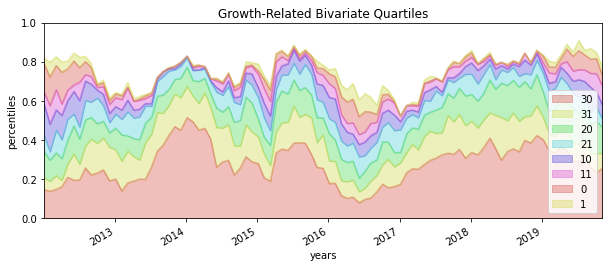

In [23]:
growth_plots = mom_rv_bp_rhos_df[[30, 31, 20, 21, 10, 11, 0, 1]].plot.area(color=pal, alpha=0.4, figsize=(10, 4))
growth_plots.set(xlabel ="years", ylabel = "percentiles", title ='Growth-Related Bivariate Quartiles')
plt.ylim(0,1)
plt.margins(x=0)
plt.show()

The top (growth) book-to-price volatility quartiles

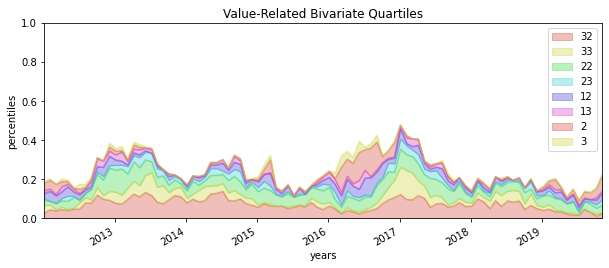

In [24]:
value_plots = mom_rv_bp_rhos_df[[32, 33, 22, 23, 12, 13, 2, 3]].plot.area(color=pal, alpha=0.4, figsize=(10, 4))
value_plots.set(xlabel ="years", ylabel = "percentiles", title ='Value-Related Bivariate Quartiles')
plt.ylim(0,1)
plt.margins(x=0)
plt.show()

<a id="section_6"></a>
## 6. Rolling the Intertemporal Analysis Approach

This section applied the intertempral analysis to the high volatility growth and value bivariate quartile. 
Similar to an event study, the portfolio formation date constitutes the event and analysis conducted across 
the ranking  and holding intervals, or before and after the event, respectively.


The code snippet below implements the function that runs portfolios (selected by query) and 
collects montly averaged field values (e.g. returns for field = '21D') across the in- and 
out-of-sample windows (wdw1 and wdw2) before and ater portfolio formation day.

In [25]:
def rolling_inout_fields(df_input, # factors and returns
                         ds,
                         wdw1, wdw2, # in- and out-of-sample windows
                         query, # query of selected factor deciles
                         field): 
    
    xs = []; ys = [] 
    
    # d21s = df_input.index.levels[0].unique()   
    # d21s = d1s.values[::21]
    
    for t in range(-wdw1, len(ds) - wdw2):
        
        df_t = []
        
        # select assets in the formation date t
        xs_t = df_input.xs(ds[t])
        assets = xs_t.query(query).index
        
        # select the subset/intersection of tradable assets 
        # in the [-window, window] interval
        
        inter_assets = assets.values
        try : 
            for dt in range(wdw1, wdw2+1):
                xs_dt = df_input.xs(ds[t+dt]).loc[inter_assets]
                xs_dt_nan = xs_dt[xs_dt[field].notnull()]           
                inter_assets = np.intersect1d(inter_assets, xs_dt_nan.index.values)
        except KeyError:
            print (ds[t+dt], 'no assets in the [index]')
            continue
        
        df_t.append(len(inter_assets))
        
        # calculate means of selected assets for [-wdw1, wdw2]  
        try : 
            for dt in range(wdw1, wdw2+1):
                xs_dt = df_input.xs(ds[t+dt]).loc[inter_assets]
                nan_sum = xs_dt[field].isnull().sum()
                if nan_sum > 0:
                    print (t, dt, 'nan:', nan_sum)
                df_t.append(xs_dt[field].mean())
        except KeyError:
            print (ds[t+dt], 'no assets in the [index]')
            continue
            
        xs.append(ds[t])
        ys.append(df_t)
        
    columns = []
    columns.append('count')
    for dt in range(wdw1, wdw2+1):
        columns.append(str(dt))
    
    df_output = pd.DataFrame(ys, index=xs, columns=columns)
    df_output.index.rename('date', inplace=True)
    
    return df_output

In [26]:
import datetime
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt

def plot_inout_rtns(all_rtns, mom10_rtns, wdw1, wdw2, query_label):

    t0 = wdw1
    t1 = wdw2 + 1

    mom10_means = [mom10_rtns[str(dt-1)].mean() for dt in range(t0, t1)]
    all_means = [all_rtns[str(dt-1)].mean() for dt in range(t0, t1)]
 
    x = range(t0, t1)

    plt.figure(figsize=(9,4))

    plt.plot(x, all_means, label=query_label, color='grey')

    mom10_label = 'mom 10 & ' + query_label
    plt.plot(x, mom10_means, label=mom10_label, color='purple')
    plt.xlim(t0, t1)

    # plt.ylim(-0.003,0.006)
    plt.xlabel('Months')
    plt.ylabel('21D')
    plt.legend(loc='upper right')

Defining the in- and out-of-sample windows

In [27]:
wdw1 = -4 # in-sample months
wdw2 = 1 # out-of-sample months

### 6.1 High Volatility Growth Stocks: RV [2, 3]  & BP [0, 1] 

Defining queries for selecting high volatility growth stocks 

In [28]:
ibp1 = 0; ibp2 = 1; irv1 = 2; irv2 = 3; 
bp_query = '{} <= bp_quartile <= {}'.format(ibp1, ibp2)
rv_query = '{} <= rv_quartile <= {}'.format(irv1, irv2)

Running a full sample

In [29]:
all_query = '{} and {}'.format(rv_query, bp_query)
all_rtns = rolling_inout_fields(asset_d21, d21s, wdw1, wdw2, all_query, field='21D') 

Running a top momentum decile

In [30]:
mom10_query = all_query + ' and mom_decile == 10'
mom10_rtns = rolling_inout_fields(asset_d21, d21s, wdw1, wdw2, mom10_query, field='21D') 

Plotting the results

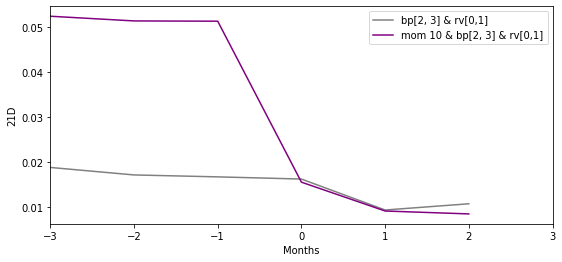

In [31]:
query_label = 'bp[{}, {}] & rv[{},{}]'.format(irv1, irv2, ibp1, ibp2)
plot_inout_rtns(all_rtns, mom10_rtns, wdw1+1, wdw2+1, query_label)

According to the intertemporal analysis, the figure includes three periods: ranking, one-month skipping, 
and holding. The diference in the ranking period between momentum winners (purple) and full sample (grey) 
quartiles is determined by the idiosyncratic returns sampled by the momentum procedure. During the skip 
interval as the ranking period ends at lag month -1 on the plot, momentum winners approach to the mean level
of high volatility stocks. After the formation date, they both experience a similiar short-term reversal. 

To summarize, the intertemporal analysis of the momentum winners decile transparently exaplain the 2011-2019 momentum premium as the sampling of high volatility growth stocks.

### 6.2 High Volatility Value Stocks: RV [2, 3] & BP [2, 3] 

The same procedure can be applied to the high volatility value stocks and explain their behavior as well.

Defining queries for selecting high volatility value stocks 

In [32]:
irv1 = 2; irv2 = 3; ibp1 = 2; ibp2 = 3
bp_query = '{} <= bp_quartile <= {}'.format(ibp1, ibp2)
rv_query = '{} <= rv_quartile <= {}'.format(irv1, irv2)

Running a full sample

In [33]:
all_query = '{} and {}'.format(rv_query, bp_query)
all_rtns = rolling_inout_fields(asset_d21, d21s, wdw1, wdw2, all_query, field='21D') 

Running a top momentum decile

In [34]:
mom10_query = all_query + ' and mom_decile == 10'
mom10_rtns = rolling_inout_fields(asset_d21, d21s, wdw1, wdw2, mom10_query, field='21D') 

Plotting the results

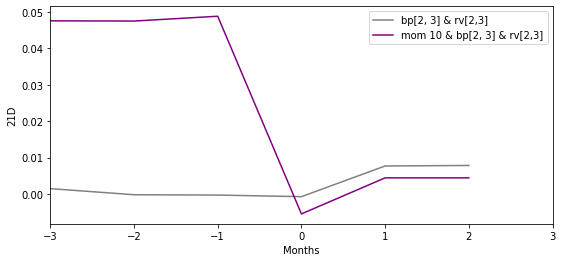

In [35]:
query_label = 'bp[{}, {}] & rv[{},{}]'.format(irv1, irv2, ibp1, ibp2)
plot_inout_rtns(all_rtns, mom10_rtns, wdw1+1, wdw2+1, query_label)